In [1]:
import os
import sys
sys.path.extend(['..'])

import itertools
import random
import time
import unittest.mock as mock

import numpy as np
import pandas as pd
import tensorflow as tf
import tensorflow_probability as tfp
import tensorboard
%load_ext tensorboard

from IPython.display import clear_output
import matplotlib.pyplot as plt
%matplotlib inline

import seaborn as sns
sns.set()

my_devices = tf.config.experimental.list_physical_devices(device_type='CPU')
tf.config.experimental.set_visible_devices(devices=my_devices, device_type='CPU')

print('Physical Devices:')
for dev in tf.config.list_physical_devices():
    print(dev)

Physical Devices:
PhysicalDevice(name='/physical_device:CPU:0', device_type='CPU')


In [2]:
from zscomm.agent import Agent
from zscomm.comm_channel import CommChannel
from zscomm.synth_teacher import SyntheticTeacher
from zscomm.play_game import *
from zscomm.loss import *
from zscomm.plot_game import plot_game

## Check that gradients can flow across channel:

In [3]:
channel = CommChannel(size=10, temperature=1, one_hot=True)

x = tf.Variable([[-1, 2, 4, 0]], dtype=tf.float32)
with tf.GradientTape() as tape:
    y = channel(x, training=True)
    
print(y)
tape.gradient(y, x)

tf.Tensor([[5.4680475e-04 6.1617009e-02 9.3747354e-01 3.6267281e-04]], shape=(1, 4), dtype=float32)


<tf.Tensor: shape=(1, 4), dtype=float32, numpy=array([[0., 0., 0., 0.]], dtype=float32)>

In [4]:
channel(x)

<tf.Tensor: shape=(1, 10), dtype=float32, numpy=array([[0., 0., 1., 0., 0., 0., 0., 0., 0., 0.]], dtype=float32)>

## Load Data:

In [5]:
NUM_CLASSES = 3
BATCH_SIZE = 32
use_mnist = False

if use_mnist:
    class_labels = list(range(NUM_CLASSES))
    (x_train, y_train), (x_test, y_test) = tf.keras.datasets.mnist.load_data()

    def preprocess_images(images):
        images = images / 255.
        return np.where(images > .5, 1.0, 0.0).astype('float32')

    x_train = preprocess_images(x_train)
    train_data = [(x, y) for x, y in zip(x_train, y_train) if y in class_labels]
    np.random.shuffle(train_data)

    x_test = preprocess_images(x_test)
    test_data = [(x, y) for x, y in zip(x_test, y_test) if y in class_labels]
    np.random.shuffle(test_data)
    
else:
    class_labels = list(range(1, 1 + NUM_CLASSES))
    sample_size = int(np.ceil(np.log2(NUM_CLASSES)))
    train_data = [
        ([0.0]*(sample_size - len(bin(l)) + 2) + [float(x) for x in bin(l)[2:]], l)
        for l in range(1, NUM_CLASSES+1)
    ]
    test_data = train_data


train_data_by_label = {
    label: [
        img for img, l in train_data
        if l == label
    ]
    for label in class_labels
}

test_data_by_label = {
    label: [
        img for img, l in test_data
        if l == label
    ]
    for label in class_labels
}

In [6]:
train_data_by_label

{1: [[0.0, 1.0]], 2: [[1.0, 0.0]], 3: [[1.0, 1.0]]}

In [7]:
def generate_batch(source, source_by_label, batch_size=BATCH_SIZE):
    inputs = []
    targets = []
    
    
    for batch in range(batch_size):
        batch_tars = []
        batch_inps = []
        
        for ts in range(NUM_CLASSES):
            sample_space = set(class_labels) - set(batch_tars)
            target = random.choice(list(sample_space))
            batch_tars.append(target)
            inp = random.choice(source_by_label[target])
            batch_inps.append(tf.constant(inp))
        
        target = random.choice(list(set(class_labels)))  
        batch_tars.append(target)
        inp = random.choice(source_by_label[target])
        batch_inps.append(tf.constant(inp))
        
        batch_tars = [
            tf.one_hot(tar-1, NUM_CLASSES)
            for tar in batch_tars
        ]
        
        inputs.append(batch_inps)
        targets.append(batch_tars)
    
    inputs = [
        tf.concat([[inputs[b][t]] for b in range(batch_size)], 0)
        for t in range(NUM_CLASSES + 1)
    ]
    inputs = tf.convert_to_tensor(inputs)
    
    targets = [
        tf.concat([[targets[b][t]] for b in range(batch_size)], 0)
        for t in range(NUM_CLASSES + 1)
    ]
    targets = tf.convert_to_tensor(targets)
    
    return inputs, targets 

def generate_train_batch():
    return generate_batch(train_data, train_data_by_label)

def generate_test_batch():
    return generate_batch(test_data, test_data_by_label)

In [8]:
inputs, targets = generate_train_batch()

In [9]:
tf.shape(inputs), tf.shape(targets)

(<tf.Tensor: shape=(3,), dtype=int32, numpy=array([ 4, 32,  2])>,
 <tf.Tensor: shape=(3,), dtype=int32, numpy=array([ 4, 32,  3])>)

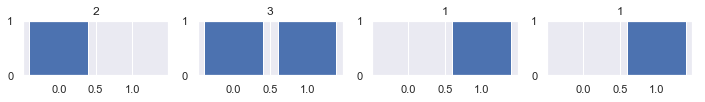

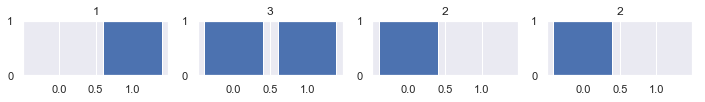

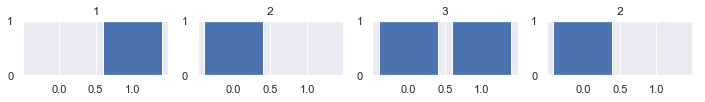

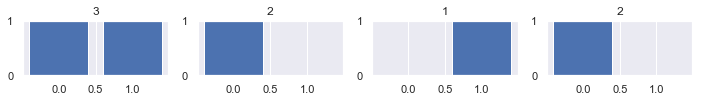

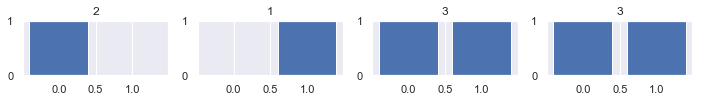

In [10]:
if use_mnist:
    figsize = (10, 10*(1 + len(class_labels)))
else:
    figsize = (3*(1 + len(class_labels)), 1)

select_batch = 0
show_rows = 5

for row in range(show_rows):
    fig, axs = plt.subplots(1, len(class_labels) + 1, 
                            figsize=figsize)
    for ax, inp, tar in zip(axs, inputs, targets):
        ax.set_title(tar[row].numpy().argmax() + 1)
        if use_mnist:
            img = inp[row].numpy()
            ax.imshow(img)
            ax.axis('off')
        else:
            domain = list(range(len(inp[row])))
            ax.bar(domain, inp[row])
            ax.set_ylim([0, 1])
            ax.set_yticks([0, 1])
    plt.show()

In [11]:
history = []
comm_channel = CommChannel(size=5, temperature=1, noise=0.5)

msg, _ = maybe_mutate_message(comm_channel.get_initial_state(5), 
                              comm_channel.size, history, 1)
history.append({'message_from_teacher': msg})
msg, _ = maybe_mutate_message(comm_channel.get_initial_state(5), 
                              comm_channel.size, history, 1)
history.append({'message_from_teacher': msg})
msg, _ = maybe_mutate_message(comm_channel.get_initial_state(5), 
                              comm_channel.size, history, 1)
history.append({'message_from_teacher': msg})
msg, _ = maybe_mutate_message(comm_channel.get_initial_state(5), 
                              comm_channel.size, history, 1)
history.append({'message_from_teacher': msg})
tf.transpose([
    tf.argmax(item['message_from_teacher'], axis=-1) 
    for item in history
])

<tf.Tensor: shape=(5, 4), dtype=int64, numpy=
array([[4, 1, 3, 2],
       [1, 3, 0, 4],
       [1, 0, 2, 4],
       [3, 4, 2, 0],
       [4, 3, 0, 1]], dtype=int64)>

## Construct Model

In [12]:
if use_mnist:
    encoder_latent_dim = 64
    _, *img_shape = x_train.shape
    encoder = tf.keras.Sequential(
        [
            tf.keras.layers.InputLayer(input_shape=img_shape),
            tf.keras.layers.Reshape(target_shape=(*img_shape, 1)),
            tf.keras.layers.Conv2D(
                filters=32, kernel_size=3, strides=(2, 2), activation='relu'),
            tf.keras.layers.Conv2D(
                filters=64, kernel_size=3, strides=(2, 2), activation='relu'),
            tf.keras.layers.Flatten(),
            # No activation
            tf.keras.layers.Dense(encoder_latent_dim),
        ]
    )

else: 
    encoder = None

CHANNEL_SIZE = 5

agent_1 = Agent(CHANNEL_SIZE, NUM_CLASSES, encoder=encoder)
agent_2 = Agent(CHANNEL_SIZE, NUM_CLASSES, encoder=encoder)

In [13]:
inputs, _ = generate_train_batch()
preds, history = play_game(inputs, agent_1, agent_1)

Check gradients:

In [14]:
inputs, targets = generate_train_batch()

teacher = agent_1
student = agent_2

with tf.GradientTape(persistent=True) as tape:
    outputs = play_game(inputs, teacher, student, 
                        training=True, 
                        p_mutate=0.5)

    loss = combined_loss_fn(outputs, targets)

teacher_grads = tape.gradient(loss, teacher.trainable_variables)
student_grads = tape.gradient(loss, teacher.trainable_variables)

for v, g in zip(agent_1.trainable_variables, teacher_grads):
    print(f'{v.name} teacher grad norm: {tf.reduce_sum(g**2)**0.5}')

print()

for v, g in zip(agent_1.trainable_variables, student_grads):
    print(f'{v.name} student grad norm: {tf.reduce_sum(g**2)**0.5}')

agent/dense/kernel:0 teacher grad norm: 0.06857147067785263
agent/dense/bias:0 teacher grad norm: 0.057139091193675995
agent/lstm/kernel:0 teacher grad norm: 0.11780910938978195
agent/lstm/recurrent_kernel:0 teacher grad norm: 0.019989535212516785
agent/lstm/bias:0 teacher grad norm: 0.04489684849977493
agent/dense_1/kernel:0 teacher grad norm: 0.05019473284482956
agent/dense_1/bias:0 teacher grad norm: 0.04300487041473389

agent/dense/kernel:0 student grad norm: 0.06857147067785263
agent/dense/bias:0 student grad norm: 0.057139091193675995
agent/lstm/kernel:0 student grad norm: 0.11780910938978195
agent/lstm/recurrent_kernel:0 student grad norm: 0.019989535212516785
agent/lstm/bias:0 student grad norm: 0.04489684849977493
agent/dense_1/kernel:0 student grad norm: 0.05019473284482956
agent/dense_1/bias:0 student grad norm: 0.04300487041473389


In [15]:
agent_1.summary()

Model: "agent"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
concatenate (Concatenate)    multiple                  0         
_________________________________________________________________
dropout (Dropout)            multiple                  0         
_________________________________________________________________
lambda (Lambda)              multiple                  0         
_________________________________________________________________
dense (Dense)                multiple                  1664      
_________________________________________________________________
lstm (LSTM)                  multiple                  49408     
_________________________________________________________________
dense_1 (Dense)              multiple                  520       
_________________________________________________________________
lambda_1 (Lambda)            multiple                  0     

In [16]:
inputs, targets = generate_train_batch()
outputs = play_game(inputs, agent_1, agent_2,
                    p_mutate=0.5, 
                    training=False)

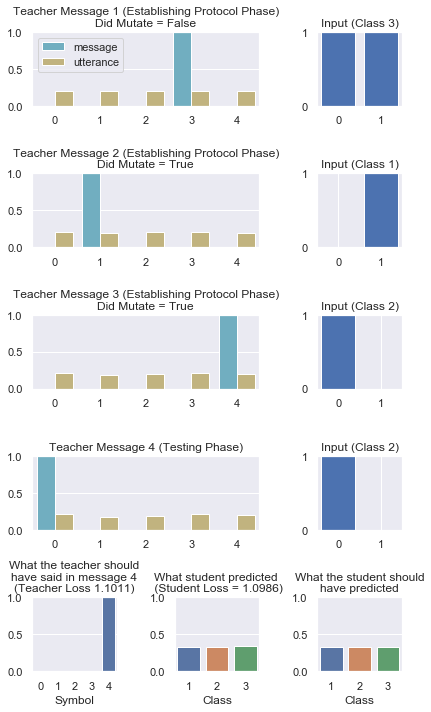

In [17]:
plot_game(inputs, outputs, targets, select_batch=1)

In [18]:
inputs, targets = generate_train_batch()

teacher = agent_1
student = mock.MagicMock(return_value=(None, None, None))


with tf.GradientTape(persistent=True) as tape:
    outputs = play_game(inputs, teacher, student, 
                        training=True, 
                        stop_gradients_on_all_comm=False,
                        p_mutate=0)

    loss = protocol_diversity_loss(outputs)

teacher_grads = tape.gradient(loss, teacher.trainable_variables)

for v, g in zip(agent_1.trainable_variables, teacher_grads):
    print(f'{v.name} teacher grad norm: {tf.reduce_sum(g**2)**0.5}')

agent/dense/kernel:0 teacher grad norm: 2.021768569946289
agent/dense/bias:0 teacher grad norm: 1.8047893047332764
agent/lstm/kernel:0 teacher grad norm: 3.2636897563934326
agent/lstm/recurrent_kernel:0 teacher grad norm: 0.43919771909713745
agent/lstm/bias:0 teacher grad norm: 1.676247239112854
agent/dense_1/kernel:0 teacher grad norm: 1.3607083559036255
agent/dense_1/bias:0 teacher grad norm: 2.4652607440948486


In [19]:
def only_student_training_step(optimiser, data, agent):
    inputs, targets = data
    teacher = SyntheticTeacher(CHANNEL_SIZE, NUM_CLASSES, targets)
    student = agent
    
    with tf.GradientTape(persistent=True) as tape:
        outputs = play_game(inputs, teacher, student, 
                            training=True, 
                            stop_gradients_on_all_comm=True,
                            p_mutate=0)
    
        loss = student_pred_matches_implied_class(outputs, targets)
    
    grads = tape.gradient(loss, agent.trainable_variables)
    optimiser.apply_gradients(zip(grads, agent.trainable_variables))

    return loss


def only_teacher_test_msg_training_step(optimiser, data, agent):
    inputs, targets = data
    teacher = agent
    student = mock.MagicMock(return_value=(None, None, None))
    
    with tf.GradientTape(persistent=True) as tape:
        outputs = play_game(inputs, teacher, student, 
                            training=True, 
                            stop_gradients_on_all_comm=True,
                            p_mutate=1)
    
        loss = teacher_test_message_is_correct(outputs, targets)
    
    grads = tape.gradient(loss, agent.trainable_variables)
    optimiser.apply_gradients(zip(grads, agent.trainable_variables))

    return loss

def only_teacher_create_protocol_training_step(optimiser, data, agent):
    inputs, targets = data
    teacher = agent
    student = mock.MagicMock(return_value=(None, None, None))
    
    with tf.GradientTape(persistent=True) as tape:
        outputs = play_game(inputs, teacher, student, 
                            training=True, 
                            stop_gradients_on_all_comm=False,
                            p_mutate=0)
    
        loss = protocol_diversity_loss(outputs)
    
    grads = tape.gradient(loss, agent.trainable_variables)
    optimiser.apply_gradients(zip(grads, agent.trainable_variables))

    return loss


def self_play_training_step(optimiser, data, agent):
    inputs, targets = data
    teacher = student = agent
    
    with tf.GradientTape(persistent=True) as tape:
        outputs = play_game(inputs, teacher, student, 
                            training=True, 
                            p_mutate=1)
    
        loss = combined_loss_fn(outputs, targets)
    
    grads = tape.gradient(loss, agent.trainable_variables)
    optimiser.apply_gradients(zip(grads, agent.trainable_variables))
    
    return loss


def other_play_training_step(optimiser, data, teacher, student):
    
    inputs, targets = data
    
    with tf.GradientTape(persistent=True) as tape:
        outputs = play_game(
            inputs, teacher, student, 
            training=True, 
            p_mutate=0.2,
#             stop_gradients_on_final_message=True
        )
    
        loss = combined_loss_fn2(outputs, targets, w=0.5)
    
    trainable_vars = teacher.trainable_variables + student.trainable_variables
    grads = tape.gradient(loss, trainable_vars)
    optimiser.apply_gradients(zip(grads, trainable_vars))
    
    return loss

# Run Experiments

In [20]:
class Experiment:
    
    def __init__(
        self, 
        training_step_fn, 
        *agents,
        max_epochs=20, 
        steps_per_epoch=50, 
        step_print_freq=5,
        lr=1e-2, # learning rate
    ):
        self.training_step_fn = training_step_fn
        self.agents = agents
        
        self.max_epochs = max_epochs
        self.steps_per_epoch = steps_per_epoch
        self.step_print_freq = step_print_freq
        
        self.training_history = []
        self.epoch = 0
        self.optimiser = tf.keras.optimizers.RMSprop(learning_rate=lr)
    
    def get_config(self):
        return {
            'max_epochs': self.max_epochs,
            'steps_per_epoch': self.steps_per_epoch,
            'epochs_optimised': self.epoch,
            'training_step_fn': str(self.training_step_fn),
            'optimiser_config': self.optimiser.get_config(),
        }
    
    def print_history(self):
        for e, item in enumerate(self.training_history):
            mins = int(item['seconds_taken']) // 60
            secs = int(item['seconds_taken']) % 60
            t = f'{mins}:{secs}'
            l = int(10000 * item['loss'].numpy().mean()) / 10000
            print(f'Epoch {e}, Time Taken (mm:ss): {t}, Loss: {l}')

    def print_step_progress(self, step, step_mean_loss):
        l = int(10000 * step_mean_loss.numpy().mean()) / 10000
        p = int(10000 * step / self.steps_per_epoch) / 100
        print(f'Epoch {self.epoch}, {p}% complete, Loss: {l}')

    def training_step(self):
        data = generate_train_batch()
        return self.training_step_fn(self.optimiser, data, *self.agents)
    
    def train(self):
        self.print_history()
        clear_output(wait=True)
        try:
            while self.epoch < self.max_epochs:
                mean_loss = tf.zeros((1,))

                start_time = time.time()
                for step in range(self.steps_per_epoch):

                    loss = self.training_step()
                    mean_loss = (mean_loss + tf.reduce_mean(loss)) / 2.0

                    if step % self.step_print_freq == 0:
                        self.print_history()
                        self.print_step_progress(step, mean_loss)
                        clear_output(wait=True)

                seconds_taken = time.time() - start_time
                self.training_history.append({
                    'loss': mean_loss, 
                    'seconds_taken': seconds_taken
                })

                self.epoch += 1
                self.print_history()
                clear_output(wait=True)

        except KeyboardInterrupt:
            pass

        self.print_history()
        print('Training stopped.')

In [21]:
agent_1 = Agent(CHANNEL_SIZE, NUM_CLASSES, encoder=encoder)
agent_2 = Agent(CHANNEL_SIZE, NUM_CLASSES, encoder=encoder)

experiment = Experiment(other_play_training_step, agent_1, agent_2,
                        max_epochs=200, lr=1e-3)
# experiment = Experiment(only_teacher_test_msg_training_step, agent_1)
# experiment = Experiment(only_teacher_create_protocol_training_step, agent_1)
# experiment = Experiment(only_student_training_step, agent_1)

print(experiment.get_config())

{'max_epochs': 200, 'steps_per_epoch': 50, 'epochs_optimised': 0, 'training_step_fn': '<function other_play_training_step at 0x000001EAA18021E0>', 'optimiser_config': {'name': 'RMSprop', 'learning_rate': 0.001, 'decay': 0.0, 'rho': 0.9, 'momentum': 0.0, 'epsilon': 1e-07, 'centered': False}}


In [22]:
experiment.train()

Epoch 0, Time Taken (mm:ss): 0:8, Loss: 1.422
Epoch 1, Time Taken (mm:ss): 0:8, Loss: 1.3005
Epoch 2, Time Taken (mm:ss): 0:8, Loss: 1.2971
Epoch 3, Time Taken (mm:ss): 0:8, Loss: 1.2055
Epoch 4, Time Taken (mm:ss): 0:8, Loss: 1.2429
Epoch 5, Time Taken (mm:ss): 0:8, Loss: 1.2068
Epoch 6, Time Taken (mm:ss): 0:8, Loss: 0.9892
Epoch 7, Time Taken (mm:ss): 0:9, Loss: 0.8791
Epoch 8, Time Taken (mm:ss): 0:8, Loss: 0.7557
Epoch 9, Time Taken (mm:ss): 0:8, Loss: 0.5237
Epoch 10, Time Taken (mm:ss): 0:16, Loss: 0.6782
Epoch 11, Time Taken (mm:ss): 0:12, Loss: 0.601
Epoch 12, Time Taken (mm:ss): 0:10, Loss: 0.5973
Epoch 13, Time Taken (mm:ss): 0:10, Loss: 0.6086
Epoch 14, Time Taken (mm:ss): 0:8, Loss: 0.5221
Epoch 15, Time Taken (mm:ss): 0:9, Loss: 0.4985
Epoch 16, Time Taken (mm:ss): 0:9, Loss: 0.4556
Epoch 17, Time Taken (mm:ss): 0:8, Loss: 0.5526
Epoch 18, Time Taken (mm:ss): 0:8, Loss: 0.5112
Epoch 19, Time Taken (mm:ss): 0:8, Loss: 0.5481
Epoch 20, Time Taken (mm:ss): 0:8, Loss: 0.4787


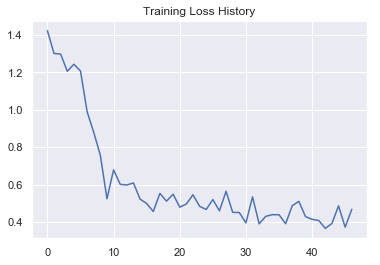

In [23]:
plt.figure()
plt.title('Training Loss History')
sns.lineplot(x=range(len(experiment.training_history)), 
             y=[item['loss'].numpy()[0] for item in experiment.training_history]);

## Render Model Graph in Tensorboard

In [24]:
# # Set up logging.
# from datetime import datetime
# stamp = datetime.now().strftime("%Y%m%d-%H%M%S")
# logdir = f'logs\\{stamp}'
# writer = tf.summary.create_file_writer(logdir)

# # Bracket the function call with
# # tf.summary.trace_on() and tf.summary.trace_export().
# tf.summary.trace_off()
# tf.summary.trace_on(graph=True, profiler=True)
# # Call only one tf.function when tracing.

# @tf.function
# def graph_training_step():
#     return only_teacher_training_step(agent_1)


# graph_training_step()

# with writer.as_default():
#     tf.summary.trace_export(
#         name="teacher_only_training_step",
#         step=0,
#         profiler_outdir=logdir)
    
# tf.summary.trace_off()

In [25]:
# %tensorboard --logdir logs

## Test Model

In [26]:
def only_student_test_play(inputs, targets):
    teacher = SyntheticTeacher(CHANNEL_SIZE, NUM_CLASSES, targets)
    student = agent_1
    return play_game(inputs, teacher, student, 
                     training=False,
                     p_mutate=0)

def only_teacher_test_play_use_protocol(inputs, targets):
    student = mock.MagicMock(return_value=(None, None, None))
    teacher = agent_1
    return play_game(inputs, teacher, student, 
                     training=False,
                     p_mutate=1)

def only_teacher_test_play_create_protocol(inputs, targets):
    student = mock.MagicMock(return_value=(None, None, None))
    teacher = agent_1
    return play_game(inputs, teacher, student, 
                     training=False,
                     p_mutate=0)

def self_play_test(inputs, targets):
    return play_game(inputs, agent_1, agent_1, 
                     training=False,
                     p_mutate=1)

def other_play_test(inputs, targets):
    return play_game(inputs, agent_1, agent_2, 
                     training=False,
                     p_mutate=0.5)

# test_play = only_student_test_play
# test_loss_fn = student_pred_matches_implied_class

# test_play = only_teacher_test_play_create_protocol
# test_loss_fn = lambda o, t: protocol_diversity_loss(o)

test_play = other_play_test
test_loss_fn = lambda o, t: combined_loss_fn2(o, t, w=0.2)

In [27]:
num_test_games = 50 # in batches

test_samples = [generate_test_batch() for _ in range(num_test_games)]

games_played = [
    (x, y, *test_play(x, y))
    for x, y in test_samples
]

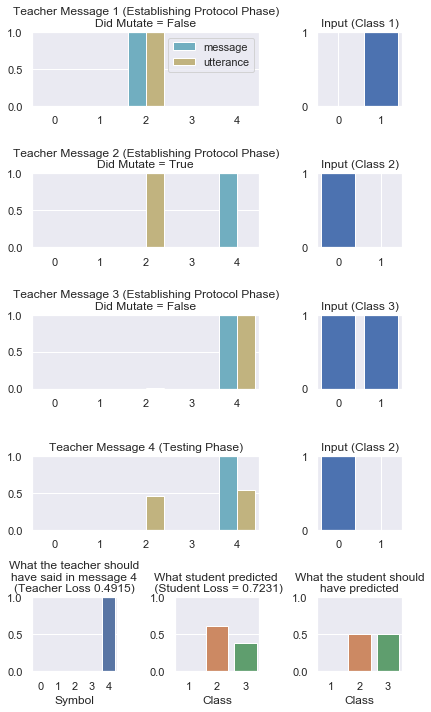

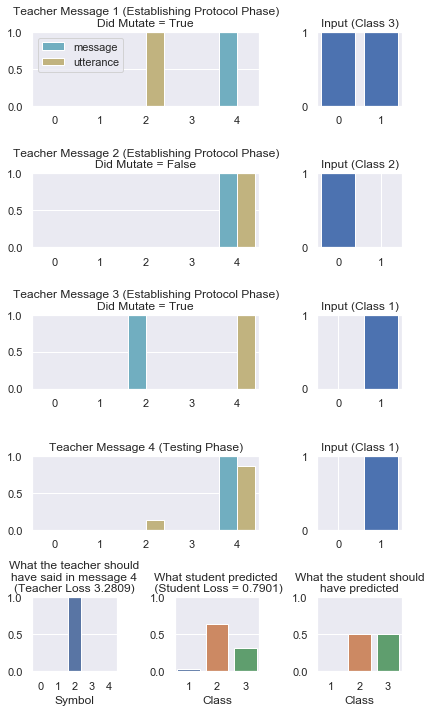

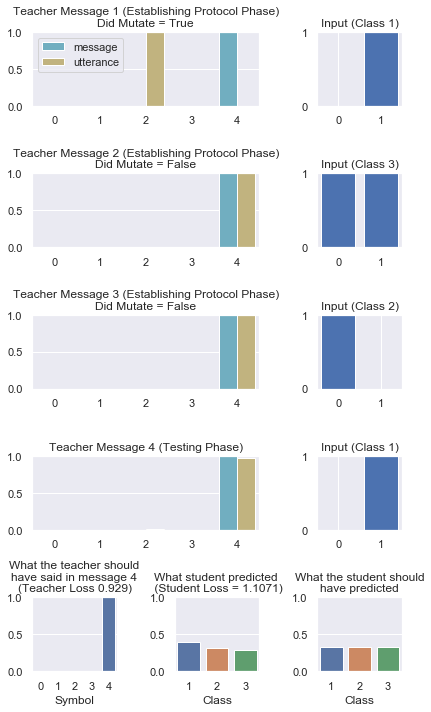

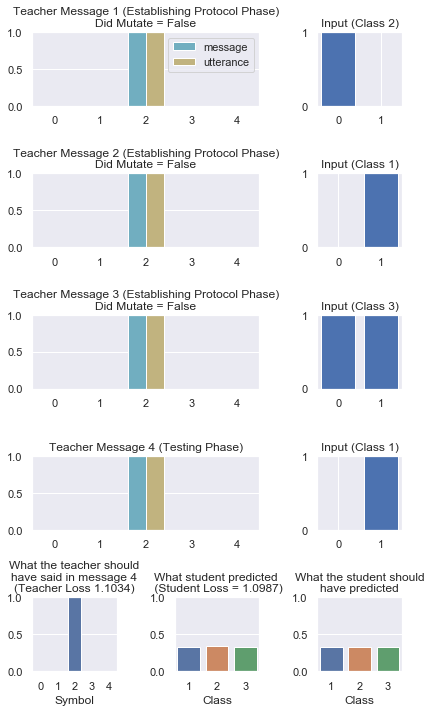

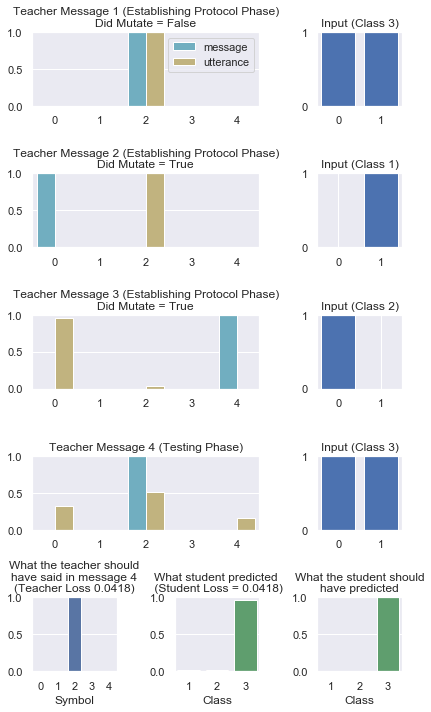

In [28]:
for i in range(5):
    inputs, targets, *outputs = games_played[5+i]
    plot_game(inputs, outputs, targets, select_batch=0)

In [29]:
test_loss = tf.zeros((1,))
for inputs, targets, *outputs in games_played:
    loss = test_loss_fn(outputs, targets)
    test_loss = (test_loss + loss) / 2
    
print(tf.reduce_mean(test_loss))

tf.Tensor(0.71442485, shape=(), dtype=float32)


In [30]:
labels = tf.concat([
    tf.argmax(y[-1], axis=-1) 
    for _, y in test_samples
], axis=0)

preds = tf.concat([
    tf.argmax(student_preds, axis=-1) 
    for _, _, student_preds, _ in games_played
], axis=0)

conf_matrix = tf.math.confusion_matrix(labels, preds)

col_totals = tf.reduce_sum(conf_matrix, axis=0)
col_totals = tf.repeat(col_totals, tf.shape(conf_matrix)[0])
col_totals = tf.reshape(col_totals, tf.shape(conf_matrix))
col_totals = tf.transpose(col_totals)

conf_matrix = (conf_matrix / col_totals).numpy()
conf_matrix[np.where(np.isnan(conf_matrix))] = 0

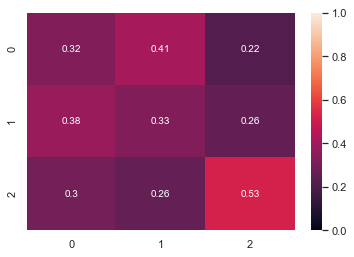

In [31]:
sns.heatmap(conf_matrix, annot=True, vmin=0, vmax=1);

The rows correspond to the true labels and the columns to the predicted labels. Each column is divided by its sum in order to show the percentage of the time the model predicts the given class.

In [32]:
messages = tf.concat([
    history[-1]['message_from_teacher'] 
    for *_, history in games_played
], axis=0)

In [33]:
def make_lm_map(label, message):
    *_, msg_size = tf.shape(message)
    lm_map_shape = (NUM_CLASSES, msg_size)
    class_indices = [i for i, _ in enumerate(class_labels)]
    indices = tf.reshape(tf.repeat(class_indices, msg_size), 
                         lm_map_shape)
    indices = tf.cast(indices, tf.int64) == label
    return message * tf.cast(indices, tf.float32)
    
*_, msg_size = tf.shape(messages)
lm_map = tf.zeros((NUM_CLASSES, msg_size))
for label, message in zip(labels, messages):
    lm_map = lm_map + make_lm_map(label, message)

row_totals = tf.reduce_sum(lm_map, axis=1)
row_totals = tf.repeat(row_totals, msg_size)
row_totals = tf.reshape(row_totals, tf.shape(lm_map))

lm_map = lm_map / row_totals

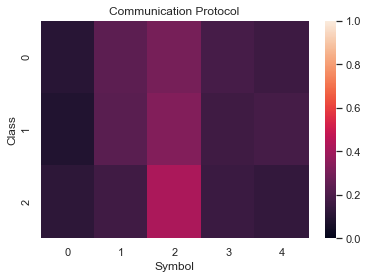

In [34]:
sns.heatmap(lm_map, vmin=0, vmax=1);
plt.ylabel('Class')
plt.xlabel('Symbol')
plt.title('Communication Protocol')
plt.show()

In [35]:
# weights_file = f'models/test/{int(time.time())}'
# weights_file

In [36]:
# model.save_weights(weights_file)